In [1]:
# module import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score


Bad key "text.kerning_factor" on line 4 in
C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# 데이터 불러오기
train = pd.read_csv('train_df.csv', encoding = 'euc-kr')
test = pd.read_csv('test.csv', encoding = 'euc-kr')

In [3]:
# Data set 정리 -> 컬럼명 변경
train.columns = ['num','date_time','target','temperature','windspeed','humidity','precipitation','sunshine','non_elec_aircon','sunlight']
test.columns = ['num','date_time','temperature','windspeed','humidity','precipitation','sunshine','non_elec_aircon','sunlight']

In [4]:
# train 데이터 세트의 date_time 컬럼의 데이터 형식 변환
train.date_time = pd.to_datetime(train['date_time'],format='%Y-%m-%d %H')
test.date_time = pd.to_datetime(test['date_time'],format='%Y-%m-%d %H')

In [5]:
# 'date_time' 컬럼을 월(month), 일(day), 요일(weekday), 시간(hor)으로 구분해 새로운 컬럼 생성
## 이때, 'weekday'는 0,1,2,3,4,5,6 순으로 월~일을 의미
## train
train['month'] = pd.to_datetime(train.date_time).dt.month
train['day'] = pd.to_datetime(train.date_time).dt.day
train['weekday'] = pd.to_datetime(train.date_time).dt.weekday
train['hour'] = pd.to_datetime(train.date_time).dt.hour
## test 
test['month'] = pd.to_datetime(test.date_time).dt.month
test['day'] = pd.to_datetime(test.date_time).dt.day
test['weekday'] = pd.to_datetime(test.date_time).dt.weekday
test['hour'] = pd.to_datetime(test.date_time).dt.hour

### 요일, 시간을 기준으로 건물별 이상치를 찾고, 값을 변경
- 값은 해당 건물의 요일, 시간 기준 이상치가 해당하는 월의 평균 값으로 대체해줌

In [6]:
train1 = train.copy()

In [7]:
def findOutliers(col):
    Q1 = train[col].quantile(.25)
    Q3 = train[col].quantile(.75)
    IQR = Q3 - Q1
    return train[(train[col] < Q1 - 1.5 * IQR)|(train[col] > Q3 + 1.5 * IQR)]

In [8]:
train1.columns[2:8]

Index(['target', 'temperature', 'windspeed', 'humidity', 'precipitation',
       'sunshine'],
      dtype='object')

In [9]:
for i in range(1,61):
    for j in range(7):
        for k in range(24):
            for col in train1.columns[2:8] :
                a = train1.loc[(train1.num == i)&(train1.weekday == j)&(train1.hour == k), col]
                q3 = a.quantile(.75)
                q1 = a.quantile(.25)
                iqr = q3 - q1
                if sum((a > q3 + 1.5*iqr) | (a < q1 - 1.5*iqr)) != 0:
                    idx = train1.loc[(train1.num == i)&(train1.weekday ==j)&(train1.hour == k)].loc[(a > q3 + 1.5*iqr) | (a < q1 - 1.5*iqr)].index.values
                    train1.at[idx, col] = None
                    train1.at[idx, col] = train1.loc[(train1.num == i)& (train1.weekday == j) & (train1.hour == k)][col].mean()

In [10]:
# 수치형 변수 스케일링
train_scale1 = train1.iloc[:, 2:8]
test_scale1 = test.iloc[:, 2:7]
train_scale1.columns

Index(['target', 'temperature', 'windspeed', 'humidity', 'precipitation',
       'sunshine'],
      dtype='object')

In [11]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
p = []
for i in range(1,61):
    train_scale2 = train_scale1.loc[train1.num==i]
    for col in ['temperature', 'windspeed', 'humidity', 'precipitation','sunshine']:
        train_scale2[col] = std_scaler.fit_transform(train_scale2[[col]])
    p.append(train_scale2)

In [12]:
m = p[0]
for i in range(1,60):
    m = m.append(p[i])
m.columns = train_scale2.columns.values
m

,target,temperature,windspeed,humidity,precipitation,sunshine
0,8557.758,-2.187330,0.248801,1.005903,-0.092528,-0.509141
1,8545.230,-2.156304,0.663464,0.941889,-0.092528,-0.509141
2,8529.084,-2.218355,0.974461,0.941889,-0.092528,-0.509141
3,8516.016,-2.342458,0.974461,0.941889,-0.092528,-0.509141
4,8507.754,-2.373484,1.078126,1.005903,-0.092528,-0.509141
...,...,...,...,...,...,...
122395,4114.368,1.548338,-0.262499,-0.932427,-0.096024,1.171011
122396,3975.696,1.374350,-1.145300,-0.715659,-0.096024,-0.590896
122397,3572.208,1.374350,-0.663772,-0.715659,-0.096024,-0.590896
122398,3299.184,1.304755,-0.663772,-0.498891,-0.096024,-0.590896


In [13]:
# 모델링용 데이터 세트 완성!!!
train_dt1 = m
train_dt1['weekday'] = train1.weekday
train_dt1['hour'] = train1.hour
train_dt1['non_elec_aircon'] = train1.non_elec_aircon
train_dt1['sunlight'] = train1.sunlight
train_dt1

,target,temperature,windspeed,humidity,precipitation,sunshine,weekday,hour,non_elec_aircon,sunlight
0,8557.758,-2.187330,0.248801,1.005903,-0.092528,-0.509141,0,0,0.0,0.0
1,8545.230,-2.156304,0.663464,0.941889,-0.092528,-0.509141,0,1,0.0,0.0
2,8529.084,-2.218355,0.974461,0.941889,-0.092528,-0.509141,0,2,0.0,0.0
3,8516.016,-2.342458,0.974461,0.941889,-0.092528,-0.509141,0,3,0.0,0.0
4,8507.754,-2.373484,1.078126,1.005903,-0.092528,-0.509141,0,4,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,4114.368,1.548338,-0.262499,-0.932427,-0.096024,1.171011,0,19,1.0,1.0
122396,3975.696,1.374350,-1.145300,-0.715659,-0.096024,-0.590896,0,20,1.0,1.0
122397,3572.208,1.374350,-0.663772,-0.715659,-0.096024,-0.590896,0,21,1.0,1.0
122398,3299.184,1.304755,-0.663772,-0.498891,-0.096024,-0.590896,0,22,1.0,1.0


In [14]:
# train, teat set 분리
from sklearn.model_selection import train_test_split

x_data1 = train_dt1.drop('target', axis=1)
y_data1 = train_dt1['target']
x_train1, x_test1, y_train1, y_test1 = train_test_split(
    x_data1, y_data1, test_size=0.2, random_state = 2021)

In [15]:
# 모델생성 1: Linear Regression
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(x_train1, y_train1)
y_pred = lm.predict(x_test1)

In [16]:
# 선형회귀의 예측 성능 확인
from sklearn.metrics import mean_squared_error # 정확도 검정
print('MSE : ',mean_squared_error(y_test1, lm.predict(x_test1)))
print('RMSE : ',(mean_squared_error(y_test1, lm.predict(x_test1)))**0.5)
print('MAPE : ',np.mean(np.abs(y_test1-y_pred)/y_test1)*100)

MSE :  4048474.175240953
RMSE :  2012.0820498282253
MAPE :  85.88216570852238


In [17]:
# 모델생성 2: RandomForest
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()
rf_reg.fit(x_train1, y_train1)
y_pred = rf_reg.predict(x_test1)
# 랜덤포레스트의 예측 성능 확인
print('MSE : ',mean_squared_error(y_test1, rf_reg.predict(x_test1)))
print('RMSE : ',(mean_squared_error(y_test1, rf_reg.predict(x_test1)))**0.5)
print('MAPE : ',np.mean(np.abs(y_test1-y_pred)/y_test1)*100)

MSE :  3631185.901458271
RMSE :  1905.5670813325546
MAPE :  61.941292226896074


In [18]:
# 모델생성 3: Decision Tree
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor()
dt_reg.fit(x_train1, y_train1)
y_pred = dt_reg.predict(x_test1)
# 의사결정나무의 예측 성능 확인
print('MSE : ',mean_squared_error(y_test1, dt_reg.predict(x_test1)))
print('RMSE : ',(mean_squared_error(y_test1, dt_reg.predict(x_test1)))**0.5)
print('MAPE : ',np.mean(np.abs(y_test1-y_pred)/y_test1)*100)

MSE :  4104054.857951803
RMSE :  2025.846701493428
MAPE :  65.76662829590273


In [19]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [20]:
# 모델생성 4: xgboost Regressor
import xgboost
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(x_train1, y_train1)
y_pred = xgb_reg.predict(x_test1)
print('MSE : ',mean_squared_error(y_test1, y_pred))
print('RMSE : ',(mean_squared_error(y_test1, y_pred))**0.5)
print('MAPE : ',np.mean(np.abs(y_test1-y_pred)/y_test1)*100)

MSE :  2212488.8335390408
RMSE :  1487.4437244948263
MAPE :  51.67995555960949


In [21]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [22]:
# 모델 생성 5: Light GBM
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

lgbm_reg = LGBMRegressor()
lgbm_reg.fit(x_train1, y_train1)
y_pred = lgbm_reg.predict(x_test1)
print('MSE : ',mean_squared_error(y_test1, y_pred))
print('RMSE : ',(mean_squared_error(y_test1, y_pred))**0.5)
print('MAPE : ',np.mean(np.abs(y_test1-y_pred)/y_test1)*100)

MSE :  2114815.4756821175
RMSE :  1454.2405150738023
MAPE :  52.16263846644088


In [23]:
# 모델 생성 6: ADABoost
from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor()
ada_reg.fit(x_train1, y_train1)
y_pred = ada_reg.predict(x_test1)
print('MSE : ',mean_squared_error(y_test1, y_pred))
print('RMSE : ',(mean_squared_error(y_test1, y_pred))**0.5)
print('MAPE : ',np.mean(np.abs(y_test1-y_pred)/y_test1)*100)

MSE :  5204746.361248943
RMSE :  2281.3913213758274
MAPE :  156.78823862472458


In [24]:
# 모델생성 7: MLP Regression
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

x_data1, y_data1 = make_regression(n_samples=200, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(x_data1, y_data1, random_state=2021)
mlp_reg = MLPRegressor(random_state=2021, max_iter=500).fit(x_train1, y_train1)
y_pred = mlp_reg.predict(x_test1)
print('MSE : ',mean_squared_error(y_test1, y_pred))
print('RMSE : ',(mean_squared_error(y_test1, y_pred))**0.5)
print('MAPE : ',np.mean(np.abs(y_test1-y_pred)/y_test1)*100)

MSE :  3795830.716560393
RMSE :  1948.2891768319182
MAPE :  80.9140861449893


## K-means Clustering

In [25]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import scale
from matplotlib import cm
import matplotlib.pyplot as plt

In [26]:
# 건물을 기준으로 하는 data frame 생성
by_weekday = train1.groupby(['num','weekday'])['target'].median().reset_index().pivot('num','weekday','target').reset_index()
by_hour = train1.groupby(['num','hour'])['target'].median().reset_index().pivot('num','hour','target').reset_index().drop('num', axis = 1)
df = pd.concat([by_weekday, by_hour], axis= 1)
columns = ['num'] + ['day'+str(i) for i in range(7)] + ['hour'+str(i) for i in range(24)]
df.columns = columns

In [27]:
# '전력사용량'이 아닌 '요일과 시간대에 따른 전력 사용량의 경향성'에 따라서만 군집화 할 것이므로, 특수한 scaling이 필요함
# standard scaling
for i in range(len(df)):
    # 요일 별 전력 중앙값에 대해 scaling
    df.iloc[i,1:8] = (df.iloc[i,1:8] - df.iloc[i,1:8].mean())/df.iloc[i,1:8].std()
    # 시간대별 전력 중앙값에 대해 scaling
    df.iloc[i,8:] = (df.iloc[i,8:] - df.iloc[i,8:].mean())/df.iloc[i,8:].std()

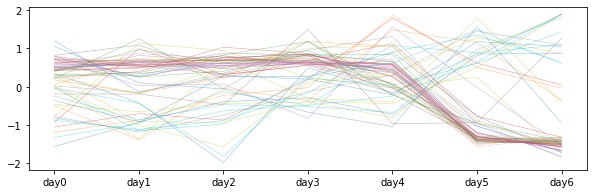

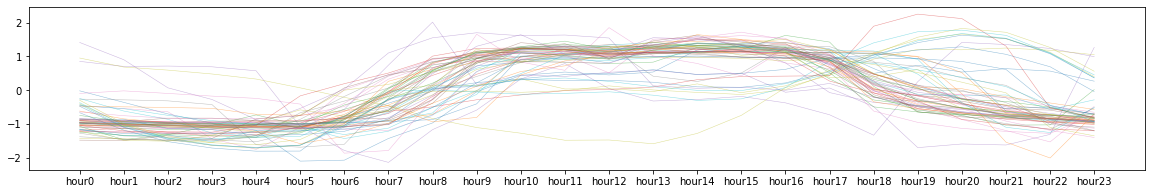

In [28]:
# visualization
fig = plt.figure(figsize = (10,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
fig = plt.figure(figsize = (20,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 8:], alpha = 0.5, linewidth = 0.5)

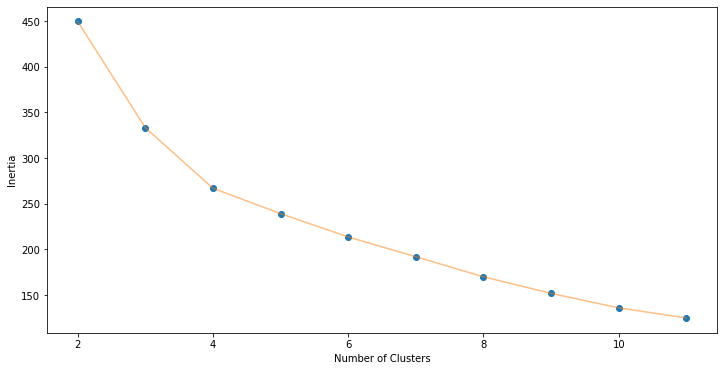

In [29]:
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], df.iloc[:,1:])

In [57]:
def Kluster(n_cluster):
    kmeans = KMeans(n_clusters=n_cluster,init='k-means++',random_state = 2)
    km_cluster = kmeans.fit_predict(df.iloc[:,1:])
    df_clust = df.copy()
    df_clust['km_cluster'] = km_cluster
    n_c = len(np.unique(df_clust.km_cluster))
    fig = plt.figure(figsize = (20,8))
    for c in range(n_c):
        temp = df_clust[df_clust.km_cluster == c]
        plt.subplot(n_c,2,2*c+1)
        for i in range(len(temp)):
            plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
            plt.title(f'cluster{c}')
            plt.xlabel('')
            plt.xticks([])
        plt.subplot(n_c,2,2*c+2)
        for i in range(len(temp)):
            plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
            plt.title(f'cluster{c}')
            plt.xlabel('')
            plt.xticks([])

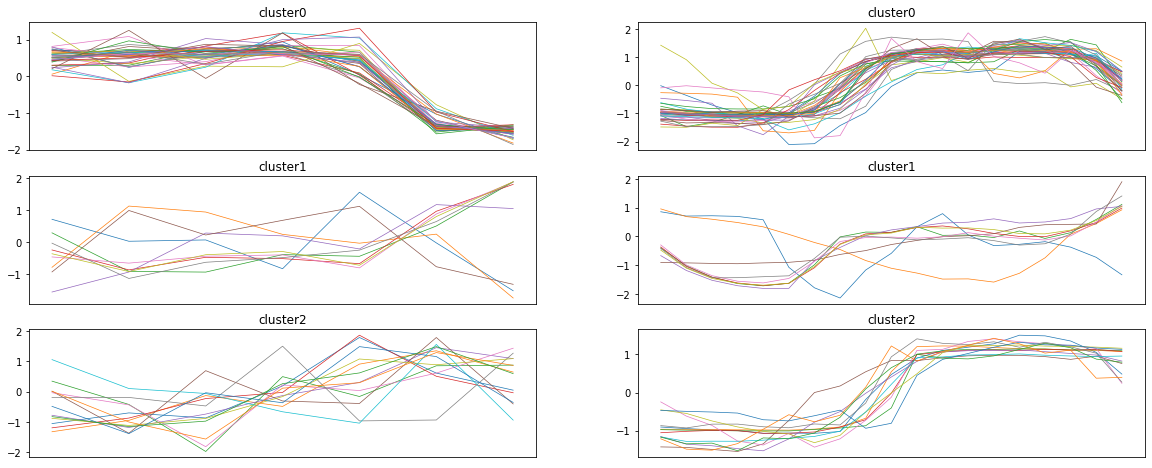

In [61]:
Kluster(3)

In [30]:
## 4-means clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(df.iloc[:,1:])
cluster = kmeans.predict(df.iloc[:,1:])

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) 
principalComponents = pca.fit_transform(df.iloc[:,1:])
# 주성분으로 이루어진 데이터 프레임 구성
principalDf = pd.DataFrame(data=principalComponents, columns = ['principal component1', 'principal component2'])
principalDf['cluster'] = cluster

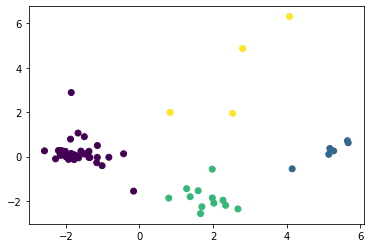

In [32]:
xs = principalDf.iloc[:,0]
ys = principalDf.iloc[:,1]
plt.scatter(x = xs, y = ys, c=principalDf['cluster'])

In [33]:
## train data set에 클러스터 번호도 넣어줌
from itertools import repeat, chain
train1['cluster'] = list(chain.from_iterable((repeat(number, 2040) for number in cluster)))

In [34]:
## 모든 변수들을 dummy화 해주면 컬럼 사이즈가 너무 커지기 떄문에 몇몇 변수들만 dummy화
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
## 시간을 더미변수화
enc_one = OneHotEncoder()
enc_one.fit(np.array(train1.hour).reshape(-1,1))
hour_dummy1 = enc_one.transform(np.array(train1.hour).reshape(-1,1)).toarray() # 시간 dummy

In [35]:
## 요일을 더미변수화
enc_one.fit(np.array(train1.weekday).reshape(-1,1))
week_dummy1 = enc_one.transform(np.array(train1.weekday).reshape(-1,1)).toarray() # 요일 dummy


In [36]:
## 냉방설비 dummy화
enc_one.fit(np.array(train1.non_elec_aircon).reshape(-1,1))
non_elec_aircon_dummy1 = enc_one.transform(np.array(train1.non_elec_aircon).reshape(-1,1)).toarray()
## 태양광 dummy
enc_one.fit(np.array(train1.sunlight).reshape(-1,1))
sunlight_dummy1 = enc_one.transform(np.array(train1.sunlight).reshape(-1,1)).toarray()

In [37]:
## dummy화 해준 것들로 새로운 train set 생성
data1 = np.concatenate([train1.iloc[:,0:8], non_elec_aircon_dummy1, sunlight_dummy1, week_dummy1, hour_dummy1, pd.DataFrame(train1.iloc[:,-1])], axis=1)
train_dummy1 = pd.DataFrame(data1)
train_dummy1.head()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,1,2020-06-01 00:00:00,8557.76,17.6,2.5,92,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3
1,1,2020-06-01 01:00:00,8545.23,17.7,2.9,91,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3
2,1,2020-06-01 02:00:00,8529.08,17.5,3.2,91,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3
3,1,2020-06-01 03:00:00,8516.02,17.1,3.2,91,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3
4,1,2020-06-01 04:00:00,8507.75,17,3.3,92,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3


In [38]:
## 클러스터별 모델링을 위해 클러스터별 데이터 생성
train1_0 = train_dummy1.loc[train_dummy1.iloc[:,-1] == 0]
train1_1 = train_dummy1.loc[train_dummy1.iloc[:,-1] == 1]
train1_2 = train_dummy1.loc[train_dummy1.iloc[:,-1] == 2]
train1_3 = train_dummy1.loc[train_dummy1.iloc[:,-1] == 3]
#train1_4 = train_dummy1.loc[train_dummy1.iloc[:,-1] == 4]

lm = LinearRegression(); rf_reg = RandomForestRegressor(); dt_reg = DecisionTreeRegressor(); xgb_reg = xgboost.XGBRegressor();

In [39]:
#MAPE(y_test, lm.predict(x_test))
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    

## 0번 클러스터

In [40]:
train_0_x = train1_0.iloc[:,3:-1]
train_0_x = train_0_x.astype('int')
y_0 = train1_0.iloc[:, 2]
y_0 = y_0.astype('int')
x_train, x_test, y_train, y_test = train_test_split(train_0_x, y_0, test_size = 0.2)
## 모델별 data fit
lm.fit(x_train, y_train); rf_reg.fit(x_train, y_train); dt_reg.fit(x_train, y_train); xgb_reg.fit(x_train, y_train); lgbm_reg.fit(x_train, y_train)
ada_reg.fit(x_train, y_train); mlp_reg.fit(x_train, y_train)
## 모델별 예측성능 비교
print('-----------------------------MAPE---------------------------------')
print('Linear: {}, Random Forest: {}, Decision Tree: {}, XGBoost Regression: {}, LGBM: {}, Ada Boost: {}, MLP: {} '.format(MAPE(y_test, lm.predict(x_test)), MAPE(y_test, rf_reg.predict(x_test)),
                                                                                                                           MAPE(y_test, dt_reg.predict(x_test)), MAPE(y_test, xgb_reg.predict(x_test)),
                                                                                                                           MAPE(y_test, lgbm_reg.predict(x_test)),
                                                                                                                           MAPE(y_test, ada_reg.predict(x_test)),
                                                                                                                           MAPE(y_test, mlp_reg.predict(x_test))))

-----------------------------MAPE---------------------------------
Linear: 70.27564898361896, Random Forest: 77.57854547102637, Decision Tree: 83.47077560334336, XGBoost Regression: 66.0699008266772, LGBM: 66.6267599824271, Ada Boost: 102.07966937332209, MLP: 67.57228660427043 


## 1번 클러스터

In [41]:
train1_1_x = train1_1.iloc[:,3:-1] 
train1_1_x = train1_1_x.astype('float')
y_1 = train1_1.iloc[:, 2]
y_1 = y_1.astype('int')
x_train, x_test, y_train, y_test = train_test_split(train1_1_x, y_1, test_size = 0.2)
## 모델별 data fit
lm.fit(x_train, y_train); rf_reg.fit(x_train, y_train); dt_reg.fit(x_train, y_train); xgb_reg.fit(x_train, y_train); lgbm_reg.fit(x_train, y_train)
ada_reg.fit(x_train, y_train); mlp_reg.fit(x_train, y_train)
## 모델별 예측성능 비교
print('-----------------------------MAPE---------------------------------')
print('Linear: {}, Random Forest: {}, Decision Tree: {}, XGBoost Regression: {}, LGBM: {}, Ada Boost: {}, MLP: {} '.format(MAPE(y_test, lm.predict(x_test)), MAPE(y_test, rf_reg.predict(x_test)),
                                                                                                                           MAPE(y_test, dt_reg.predict(x_test)), MAPE(y_test, xgb_reg.predict(x_test)),
                                                                                                                           MAPE(y_test, lgbm_reg.predict(x_test)),
                                                                                                                           MAPE(y_test, ada_reg.predict(x_test)),
                                                                                                                           MAPE(y_test, mlp_reg.predict(x_test))))

-----------------------------MAPE---------------------------------
Linear: 15.877816750716825, Random Forest: 15.131385594631878, Decision Tree: 18.376416925687696, XGBoost Regression: 13.789367366855323, LGBM: 13.169119740557356, Ada Boost: 26.117683857406636, MLP: 14.545762870735878 


## 2번 클러스터

In [42]:
train_2_x = train1_2.iloc[:,3:-1]
train_2_x = train_2_x.astype('float')
y_2 = train1_2.iloc[:, 2]
y_2 = y_2.astype('int')
x_train, x_test, y_train, y_test = train_test_split(train_2_x, y_2, test_size = 0.2)
## 모델별 data fit
lm.fit(x_train, y_train); rf_reg.fit(x_train, y_train); dt_reg.fit(x_train, y_train); xgb_reg.fit(x_train, y_train); lgbm_reg.fit(x_train, y_train)
ada_reg.fit(x_train, y_train); mlp_reg.fit(x_train, y_train)
## 모델별 예측성능 비교
print('-----------------------------MAPE---------------------------------')
print('Linear: {}, Random Forest: {}, Decision Tree: {}, XGBoost Regression: {}, LGBM: {}, Ada Boost: {}, MLP: {} '.format(MAPE(y_test, lm.predict(x_test)), MAPE(y_test, rf_reg.predict(x_test)),
                                                                                                                           MAPE(y_test, dt_reg.predict(x_test)), MAPE(y_test, xgb_reg.predict(x_test)),
                                                                                                                           MAPE(y_test, lgbm_reg.predict(x_test)),
                                                                                                                           MAPE(y_test, ada_reg.predict(x_test)),
                                                                                                                           MAPE(y_test, mlp_reg.predict(x_test))))

-----------------------------MAPE---------------------------------
Linear: 77.94173512342302, Random Forest: 68.98687906623879, Decision Tree: 76.27589786334454, XGBoost Regression: 64.46347786235862, LGBM: 64.14199664547607, Ada Boost: 136.23021185187548, MLP: 69.001835543646 


## 3번 클러스터

In [43]:
train_3_x = train1_3.iloc[:,3:-1]
train_3_x = train_3_x.astype('float')
y_3 = train_3_x.iloc[:, 2]
y_3 = y_3.astype('int')
x_train, x_test, y_train, y_test = train_test_split(train_3_x, y_3, test_size = 0.2)
## 모델별 data fit
lm.fit(x_train, y_train); rf_reg.fit(x_train, y_train); dt_reg.fit(x_train, y_train); xgb_reg.fit(x_train, y_train); lgbm_reg.fit(x_train, y_train)
ada_reg.fit(x_train, y_train); mlp_reg.fit(x_train, y_train)
## 모델별 예측성능 비교
print('-----------------------------MAPE---------------------------------')
print('Linear: {}, Random Forest: {}, Decision Tree: {}, XGBoost Regression: {}, LGBM: {}, Ada Boost: {}, MLP: {} '.format(MAPE(y_test, lm.predict(x_test)), MAPE(y_test, rf_reg.predict(x_test)),
                                                                                                                           MAPE(y_test, dt_reg.predict(x_test)), MAPE(y_test, xgb_reg.predict(x_test)),
                                                                                                                           MAPE(y_test, lgbm_reg.predict(x_test)),
                                                                                                                           MAPE(y_test, ada_reg.predict(x_test)),
                                                                                                                           MAPE(y_test, mlp_reg.predict(x_test))))

-----------------------------MAPE---------------------------------
Linear: 0.03012587057278724, Random Forest: 0.004464081118004781, Decision Tree: 0.0023156576009415665, XGBoost Regression: 0.00546178043266783, LGBM: 0.04300461470017352, Ada Boost: 0.8881219429628667, MLP: 0.05328215826048975 


In [44]:
#train_4_x = train1_4.iloc[:,3:-1]
#train_4_x = train_4_x.astype('float')
#y_3 = train_3_x.iloc[:, 2]
#x_train, x_test, y_train, y_test = train_test_split(train_3_x, y_3, test_size = 0.2)
## 모델별 data fit
#lm.fit(x_train, y_train); rf_reg.fit(x_train, y_train); dt_reg.fit(x_train, y_train); xgb_reg.fit(x_train, y_train)
## 모델별 예측성능 비교
#print('-----------------------------MSE---------------------------------')
#print('Linear: {}, Random Forest: {}, Decision Tree: {}, XGBoost Regression: {}'.format(mean_squared_error(lm.predict(x_test), y_test), 
#      mean_squared_error(rf_reg.predict(x_test), y_test),
#      mean_squared_error(dt_reg.predict(x_test), y_test),
#      mean_squared_error(xgb_reg.predict(x_test), y_test)))
#print('-----------------------------MAPE---------------------------------')
#print('Linear: {}, Random Forest: {}, Decision Tree: {}, XGBoost Regression: {}'.format(MAPE(y_test, lm.predict(x_test)), MAPE(y_test, rf_reg.predict(x_test)),
#                                                                                       MAPE(y_test, dt_reg.predict(x_test)), MAPE(y_test, xgb_reg.predict(x_test))))

In [45]:
for i in range(1,61):
    temp_data1 = train_dummy1.loc[train_dummy1.iloc[:,0] == i]
    X_temp1 = temp_data1.iloc[:,3:-1]
    y_temp1= temp_data1.iloc[:, 2]
    x_train1, x_test1, y_train1, y_test1 = train_test_split(X_temp1, y_temp1, test_size = 0.2)
    x_train1 = x_train1.astype('float')
    x_test1 = x_test1.astype('float')
    y_train1 = y_train1.astype('float')
    y_test1 = y_test1.astype('float')
    globals()['lm1{}'.format(i)] = LinearRegression()
    globals()['rf_reg1{}'.format(i)] = RandomForestRegressor()
    globals()['dt_reg1{}'.format(i)] = DecisionTreeRegressor()
    globals()['xgb_reg1{}'.format(i)] = xgboost.XGBRegressor()
    globals()['lgbm_reg1{}'.format(i)] = LGBMRegressor()
    globals()['ada_reg1{}'.format(i)] = AdaBoostRegressor()
    globals()['mlp_reg1{}'.format(i)] = MLPRegressor(random_state=2021, max_iter=500)

    ## 모델별 data fit
    globals()['lm1{}'.format(i)].fit(x_train1, y_train1)
    globals()['rf_reg1{}'.format(i)].fit(x_train1, y_train1)
    globals()['dt_reg1{}'.format(i)].fit(x_train1, y_train1)
    globals()['xgb_reg1{}'.format(i)].fit(x_train1, y_train1)
    globals()['lgbm_reg1{}'.format(i)].fit(x_train1, y_train1)
    globals()['ada_reg1{}'.format(i)].fit(x_train1, y_train1)
    globals()['mlp_reg1{}'.format(i)].fit(x_train1, y_train1)
    ## 모델별 예측성능 비교
    print('----------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Linear: {}, Random Forest: {}, Decision Tree: {}, XGBoost Regression: {}, LGBM: {}, Ada: {}, MLP: {}'.format(MAPE(globals()['lm1{}'.format(i)].predict(x_test1), y_test1),
    MAPE(globals()['rf_reg1{}'.format(i)].predict(x_test1), y_test1),
    MAPE(globals()['dt_reg1{}'.format(i)].predict(x_test1), y_test1),
    MAPE(globals()['xgb_reg1{}'.format(i)].predict(x_test1),y_test1),
    MAPE(globals()['lgbm_reg1{}'.format(i)].predict(x_test1),y_test1),
    MAPE(globals()['ada_reg1{}'.format(i)].predict(x_test1),y_test1),
    MAPE(globals()['mlp_reg1{}'.format(i)].predict(x_test1),y_test1)))
    

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Linear: 0.5848069374363034, Random Forest: 0.4381065783815636, Decision Tree: 0.5766977960943886, XGBoost Regression: 0.4285759446649261, LGBM: 0.42284724532971496, Ada: 0.568621830826701, MLP: 5.776138162881721
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Linear: 10.044181336674175, Random Forest: 3.146938657184508, Decision Tree: 3.9651787736653574, XGBoost Regression: 4.014450561681677, LGBM: 4.016704017330807, Ada: 13.96116432119658, MLP: 8.93289303604757
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Linear: 2.704263236958303, Random Forest: 2.44411940829432, De

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Linear: 8.364416920048146, Random Forest: 5.146081440022607, Decision Tree: 6.6835632210252, XGBoost Regression: 5.109293788023799, LGBM: 5.1001155183388605, Ada: 13.246296917481873, MLP: 7.9623015302756786
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Linear: 4.589362547061629, Random Forest: 3.6555362902520634, Decision Tree: 5.003789409317659, XGBoost Regression: 3.769283770027312, LGBM: 3.4462491521461027, Ada: 5.2939211812559135, MLP: 4.8404936228958
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Linear: 16.19282280180615, Random Forest: 6.718309034219059, Decisi

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Linear: 7.4692912781409815, Random Forest: 5.5716265983780415, Decision Tree: 7.109075552151165, XGBoost Regression: 5.158258769128473, LGBM: 5.182302386845829, Ada: 14.455006846193038, MLP: 8.29347373528914
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Linear: 34.566553740680526, Random Forest: 5.462277633854859, Decision Tree: 6.862080864461703, XGBoost Regression: 5.568836881251188, LGBM: 5.536657702198846, Ada: 29.21173361930408, MLP: 19.095964665247017
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Linear: 14.312287228366829, Random Forest: 4.342801683519614, Dec

A = []; B =[]; C = []; D = []; E = []; F = []; G = []; H = []
for i in range(1,61):
    temp_data = train_dummy.loc[train_dummy.iloc[:,0] == i]
    temp_data1 = train_dummy1.loc[train_dummy.iloc[:,0] == i]
    X_temp = temp_data.iloc[:,3:-1]
    X_temp1 = temp_data1.iloc[:,3:-1]
    y_temp= temp_data.iloc[:, 2]
    y_temp1= temp_data1.iloc[:, 2]
    x_train, x_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size = 0.2)
    x_train1, x_test1, y_train1, y_test1 = train_test_split(X_temp1, y_temp1, test_size = 0.2)
    globals()['lm{}'.format(i)] = LinearRegression()
    globals()['rf_reg{}'.format(i)] = RandomForestRegressor()
    globals()['dt_reg{}'.format(i)] = DecisionTreeRegressor()
    globals()['lm1{}'.format(i)] = LinearRegression()
    globals()['rf_reg1{}'.format(i)] = RandomForestRegressor()
    globals()['dt_reg1{}'.format(i)] = DecisionTreeRegressor()

    ## 모델별 data fit
    globals()['lm{}'.format(i)].fit(x_train, y_train)
    globals()['rf_reg{}'.format(i)].fit(x_train, y_train)
    globals()['dt_reg{}'.format(i)].fit(x_train, y_train)
    globals()['lm1{}'.format(i)].fit(x_train1, y_train1)
    globals()['rf_reg1{}'.format(i)].fit(x_train1, y_train1)
    globals()['dt_reg1{}'.format(i)].fit(x_train1, y_train1)
    ## 모델별 예측성능 비교
    A.append(mean_squared_error(globals()['lm{}'.format(i)].predict(x_test), y_test))
    B.append(mean_squared_error(globals()['rf_reg{}'.format(i)].predict(x_test), y_test))
    C.append(mean_squared_error(globals()['dt_reg{}'.format(i)].predict(x_test), y_test))
    D.append(MAPE(globals()['lm{}'.format(i)].predict(x_test), y_test))
    E.append(mean_squared_error(globals()['lm1{}'.format(i)].predict(x_test1), y_test1))
    F.append(mean_squared_error(globals()['rf_reg1{}'.format(i)].predict(x_test1), y_test1))
    G.append(mean_squared_error(globals()['dt_reg1{}'.format(i)].predict(x_test1), y_test1))
    H.append(MAPE(globals()['lm1{}'.format(i)].predict(x_test1), y_test1))
    
dd = pd.DataFrame(np.array([A,B,C,D,E,F,G,H]).reshape(-1,8), columns = ['lm', 'rf', 'dt', 'lm_mape', 'lm1', 'rf1', 'dt1', 'lm1_mape'])
dd['num'] = range(1,61)
import plotly.express as px
plt.plot(dd.num, dd.lm, marker='s', color='r')
plt.plot(dd.num, dd.lm1, marker='o', color='g')

plt.plot(dd.num, dd.rf, marker='s', color='r')
plt.plot(dd.num, dd.rf1, marker='o', color='g')

plt.plot(dd.num, dd.dt, marker='s', color='r')
plt.plot(dd.num, dd.dt1, marker='o', color='g')

plt.plot(dd.num, dd.lm_mape, marker='s', color='r')
plt.plot(dd.num, dd.lm1_mape, marker='o', color='g')

# 성능개선

In [46]:
# 상관관계 파악
train_dt1.corr()['target'].to_frame().style.background_gradient(cmap='summer_r')

,target
target,1
temperature,0.148337
windspeed,0.0880928
humidity,-0.0973204
precipitation,0.0035506
sunshine,0.121109
weekday,-0.0578148
hour,0.090305
non_elec_aircon,0.153787
sunlight,0.116965


In [47]:
# 다중공선성 확인
x_data_ = train_dt1.drop('target', axis = 1)

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_data_.values, i) for i in range(x_data_.shape[1])]
vif["features"] = x_data_.columns
vif.sort_values(by='VIF Factor', ascending = False)

,VIF Factor,features
6,2.875776,hour
7,2.519898,non_elec_aircon
5,2.432387,weekday
2,2.056819,humidity
4,2.024529,sunshine
8,1.800018,sunlight
0,1.571940,temperature
1,1.148862,windspeed
3,1.010573,precipitation


# Dash 만들기!

In [48]:
import pandas as pd
import numpy as np
import plotly.express as px

import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
import dash_table
from dash.dependencies import Input, Output, State
import plotly.graph_objects as go

In [49]:
input_building = \
        html.Div([
        dbc.Label("건물번호 : "),
        dcc.Input(
            id = 'input-building',
            placeholder='Building Num', 
            type="number",
            style={'width': '165px'}  )
])



input_temp = \
        html.Div([
        dbc.Label(" 기 온 : "),
        dcc.Input(
            id = 'input-temperature',
            placeholder='Temperature', 
            type="number",
            style={'width': '190px'}  )
])

input_wind = \
        html.Div([
        dbc.Label(" 풍 속 : "),
        dcc.Input(
            id = 'input-windspeed',
            placeholder='Windspeed', 
            type="number",
            style={'width': '190px'}  )
])

input_humidity = \
        html.Div([
        dbc.Label(" 습 도 : "),
        dcc.Input(
            id = 'input-humidity',
            placeholder='Humidity', 
            type="number",
            style={'width': '190px'}  )
])
input_precipitation = \
        html.Div([
        dbc.Label(" 강 수 : "),
        dcc.Input(
            id = 'input-precipitation',
            placeholder='Precipitation', 
            type="number",
            style={'width': '190px'} )
])


input_sunshine = \
        html.Div([
        dbc.Label(" 일 조 : "),
        dcc.Input(
            id = 'input-sunshine',
            placeholder='Sunshine', 
            type="number",
            style={'width': '190px'} )
])
    

non_elec_aircon_dropdown = \
html.Div([
        dbc.Row([
            dbc.Col(
                dbc.Label(" 비전력 : ")
            ),
            dbc.Col( 
                dcc.RadioItems(
                        id = 'input-non-elec-aircon',
                        options = [{'label':'보유', 'value': 1},
                                  {'label':'미보유', 'value': 0}
                                  ],
                    
                        value = 0,
                        style = {'width' : '180px'}
                    )
                    
                )
        ])        
])




sunlight_dropdown = \
html.Div([
        dbc.Row([
            dbc.Col(
                dbc.Label(" 태양광 : ")
            ),
            dbc.Col( 
                dcc.RadioItems(
                        id = 'input-sunlight',
                        options = [{'label':'보유', 'value': 1},
                                  {'label':'미보유', 'value': 0}
                                  ],
                    
                        value = 0,
                        style = {'width' : '180px'}
                    )
                    
                )
        ])        
])


weekday_dropdown = \
html.Div([
        dbc.Row([
            dbc.Col(
                dbc.Label(" 요 일 : ")
            ),
            dbc.Col( 
                dcc.Dropdown(
                        id = 'input-weekday',
                        options = [{'label':'월', 'value': 0},
                                  {'label':'화', 'value': 1},
                                  {'label':'수', 'value': 2},
                                  {'label':'목', 'value': 3},
                                  {'label':'금', 'value': 4},
                                  {'label':'토', 'value': 5},
                                  {'label':'일', 'value': 6}
                                  ],
                        value = 0,
                        style = {'width' : '160px'}
                    )
    
                )
        ])        
])

input_hour = \
html.Div([
        dbc.Row([
            dbc.Col(
                dbc.Label(" 시 간 : ")
            ),
            dbc.Col( 
                dcc.Input(
                        id = 'input-hour',
                        type = 'number'
                    )

                )
        ])        
])




pred_val =\
html.Button(
    '확인',
    id = 'pred-val',
    n_clicks = 0
)

head_data_table = \
dash_table.DataTable(
    id = 'head-table'
)

tail_data_table = \
dash_table.DataTable(
    id = 'tail-table'
)


usage_graph = \
dcc.Graph(
    id = 'my-usage',
    style={'width': '600px'}
)

compare_graph = \
dcc.Graph(
    id = 'compare-kluster'
)

unknown = \
html.H2(
    id = 'unknown'
)

my_gauge = \
dcc.Graph(
    id = 'my-gauge'
)

line_chart =\
dcc.Graph(
    id = 'line-chart'
)

week_hour = \
html.Div([
        dbc.Row(
            dbc.Col( 
                dcc.RadioItems(
                        id = 'input-weekhour',
                        options = [{'label':'요일', 'value': 1},
                                  {'label':'시간', 'value': 0}
                                  ],
                    
                        value = 0,
                        style = {'width' : '180px'}
                    )
                    
                )
        )
        ]
)

In [50]:
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.GRID])
app.layout = html.Div(
[
             ## row1
                dbc.Row(
                    [
                        dbc.Col(
                            [   
                                
                                dbc.Row(html.H2('건물정보 입력')),
                                dbc.Row(input_building),
                                dbc.Row(input_temp),
                                dbc.Row(input_wind),
                                dbc.Row(input_humidity),
                                dbc.Row(input_precipitation),
                                dbc.Row(input_sunshine),
                                dbc.Row(non_elec_aircon_dropdown),
                                dbc.Row(sunlight_dropdown),
                                dbc.Row(weekday_dropdown),
                                html.Div(
                                            [
                                                dbc.Row(
                                                    [
                                                        dbc.Col(input_hour,
                                                                width = '150px'),
                                                        dbc.Col(pred_val)
                                                    ]
                                                )
                                            ]
                                        ) 
                            ],
                            width={"size": 5, "offset": 1}
                        ),
                        
                        dbc.Col( [
                            dbc.Row(id='unknown'),
                            dbc.Row(my_gauge)
                        ]
                        )
                    ]
                ),
            
            ##row2
            dbc.Row(
                [
                    dbc.Col(usage_graph),
                    dbc.Col(
                        [
                        dbc.Row(week_hour),
                        dbc.Row(line_chart)
                        ]
                        )
                    ]
                )
    ]
)
            
        
        


In [51]:
def weekday(key):
    week = {0 : 9,
             1 : 10,
             2 : 11,
             3 : 12,
             4 : 13,
             5 : 14,
             6 : 15}
    return week.get(key)

In [52]:
@app.callback(
     Output('unknown','children'),
     Output('my-usage','figure'),
     Input('pred-val','n_clicks'),
     State('input-building','value')
)


def forecast(n_click,num):
    a = MAPE(globals()['lm1{}'.format(num)].predict(x_test1), y_test1)
    b = MAPE(globals()['rf_reg1{}'.format(num)].predict(x_test1), y_test1)
    c = MAPE(globals()['dt_reg1{}'.format(num)].predict(x_test1), y_test1)
    d = MAPE(globals()['lgbm_reg1{}'.format(num)].predict(x_test1),y_test1)
    e = MAPE(globals()['ada_reg1{}'.format(num)].predict(x_test1),y_test1)
    f = MAPE(globals()['mlp_reg1{}'.format(num)].predict(x_test1),y_test1)
    g = min(a,b,c,d,e,f)
    if g == a:
        h = 'Linear Regression'
    elif g == b:
        h = 'Random Forest Regressor'
    elif g == c:
        h = 'Decision Tree Regressor'
    elif g == d:
        h = 'LGBM Regressor'
    elif g == e:
        h = 'Ada Boost Regressor'
    else:
        h = 'MLP Regressor'
        
    df=train1[train1.num==num]
    df=df.groupby(['weekday','hour'])['target'].mean().reset_index().pivot('weekday','hour','target')
    fig = px.imshow(df)
    fig.update_layout(
    title='요일별 시간별 전력사용량 패턴',
    xaxis_nticks=36)
    
    return html.H2('Forecast Model : {}'.format(h)),fig

In [53]:
@app.callback(
    Output('my-gauge','figure'),
    Input('pred-val','n_clicks'),
    State('input-building','value'),
    State('input-temperature','value'),
    State('input-windspeed','value'),
    State('input-humidity','value'),
    State('input-precipitation','value'),
    State('input-sunshine','value'),
    State('input-non-elec-aircon','value'),
    State('input-sunlight','value'),
    State('input-weekday','value'),
    State('input-hour','value')
    
)

def update_my_graph(n_click, num, temp,wind,humidity, precipitation, sunshine, non_ead, sunlight, week, hour):
    data_input = [0] * 40
    data_input[0] = temp
    data_input[1] = wind
    data_input[2] = humidity
    data_input[3] = precipitation
    data_input[4] = sunshine
    if non_ead == 0:
        data_input[5] = 1
    else:
        data_input[6] = 1
    if sunlight == 0:
        data_input[7] = 1
    else:
        data_input[8] = 1
    data_input[weekday(week)] = 1
    hour %= 24
    data_input[hour+16] = 1
    
    data_input = [data_input]
    figure = go.Figure(go.Indicator(
        mode = "gauge+number",
        value = globals()['rf_reg1{}'.format(num)].predict(data_input)[0],
        domain = {'x': [0, 1], 'y': [0, 1]},
        gauge = {'axis': {'range': [None, 10000]}, 'bar': {'color': "darkblue"}},
        title = {'text': "예측 전력 사용량"}))
    return figure

In [54]:
@app.callback(
    Output('line-chart','figure'),
    Input('pred-val','n_clicks'),
    Input('input-weekhour','value'),
    State('input-building','value'),
)

def update_line_chart(n_clicks, value, num):
    df = train1.loc[train1.num == num]
    figure = go.Figure()
    if value == 0:
        dt_mean = df.groupby(['hour'])['target'].mean().reset_index()
        dt_max = df.groupby(['hour'])['target'].max().reset_index()
        dt_min = df.groupby(['hour'])['target'].min().reset_index()
        figure.add_trace(go.Scatter(x=np.array(dt_mean.hour), y=np.array(dt_mean.target),
                    mode='lines',
                    name='hour_mean'))
        figure.add_trace(go.Scatter(x=np.array(dt_max.hour), y=np.array(dt_max.target),
                    mode='lines',
                    name='hour_max'))
        figure.add_trace(go.Scatter(x=np.array(dt_min.hour), y=np.array(dt_min.target),
                    mode='lines',
                    name='hour_min'))
    else:
        dt_mean = df.groupby(['weekday'])['target'].mean().reset_index()
        dt_max = df.groupby(['weekday'])['target'].max().reset_index()
        dt_min = df.groupby(['weekday'])['target'].min().reset_index()
        figure.add_trace(go.Scatter(x=np.array(dt_mean.weekday), y=np.array(dt_mean.target),
                    mode='lines',
                    name='weekday_mean'))
        figure.add_trace(go.Scatter(x=np.array(dt_max.weekday), y=np.array(dt_max.target),
                    mode='lines',
                    name='weekday_max'))
        figure.add_trace(go.Scatter(x=np.array(dt_min.weekday), y=np.array(dt_min.target),
                    mode='lines',
                    name='weekday_min'))
        

    figure.update_layout(
            title = 'Amount of Electricity Used',
            xaxis=dict(
            showline=True,
            showgrid=False,
            showticklabels=True,
            linecolor='black',
            linewidth=2,
            ticks='outside',
            tickfont=dict(
                family='Arial',
                size=12,
                color='black',
            ),
        ),
        yaxis=dict(
            showgrid=True,
            zeroline=True,
            showline=True,
            showticklabels=True,
        ),
        autosize=False,
        margin=dict(
            autoexpand=True,
            l=100,
            r=20,
            t=110,
        ),
        showlegend=True,
        plot_bgcolor='white')

    return figure

In [56]:
app.run_server(port='7777')

Dash is running on http://127.0.0.1:7777/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:7777/ (Press CTRL+C to quit)
127.0.0.1 - - [04/Jun/2021 15:57:57] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2021 15:57:58] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2021 15:57:58] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2021 15:57:58] "GET /_favicon.ico?v=1.20.0 HTTP/1.1" 200 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\admin\Anaconda3\lib\site-packages\flask\app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\admin\Anaconda3\lib\site-packages\flask\app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\admin\Anaconda3\lib\site-packages\flask\app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\admin\Anaconda3\lib\site-packages\flask\_compat.py", line 39, in reraise
    raise value
  File "C:\Users\admin\Anaconda3\lib\site-packages\flask\app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\admin\Anaconda3\lib\site-packages\flask\app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dash\dash.py", line 1079, in dispatch
    response.set_d

127.0.0.1 - - [04/Jun/2021 15:57:58] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\admin\Anaconda3\lib\site-packages\flask\app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\admin\Anaconda3\lib\site-packages\flask\app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\admin\Anaconda3\lib\site-packages\flask\app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\admin\Anaconda3\lib\site-packages\flask\_compat.py", line 39, in reraise
    raise value
  File "C:\Users\admin\Anaconda3\lib\site-packages\flask\app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\admin\Anaconda3\lib\site-packages\flask\app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "C:\Users\admin\Anaconda3\lib\site-packages\dash\dash.py", line 1079, in dispatch
    response.set_d

127.0.0.1 - - [04/Jun/2021 15:57:58] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [04/Jun/2021 15:57:58] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2021 15:58:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2021 15:58:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2021 15:58:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2021 15:58:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2021 15:58:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2021 15:58:31] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2021 15:58:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2021 15:58:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2021 15:58:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [04/Jun/2021 15:58:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.